# Model to predict a tip

To suggest a tip amount to the rider I produced a model based on the NY yellow taxi data.
- This data can be found here: (http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml) and is described by the data dictionary at (http://www.nyc.gov/html/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

## Data preparation 

In [1]:
from scipy import stats
from scipy.stats import lognorm, spearmanr, linregress
import random
import pandas as pd
import numpy as np
import datetime as dt
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import pysal as ps
from pylab import figure, scatter, show
import math
import statsmodels.api as sm 
from scipy.interpolate import interp1d

from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

C:\Users\hyelim\Anaconda3\lib\site-packages\pysal\__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://pysal.org/about
  ), VisibleDeprecationWarning)


In [2]:
allFiles = glob.glob("*.csv")
frame = pd.DataFrame()
list_ = []

for file_ in allFiles:
    num_lines = sum(1 for l in open(file_))
    # Sample size - in this case ~1%
    size = int(num_lines / 100)

    skip_idx = random.sample(range(1, num_lines), num_lines - size)

    df = pd.read_csv(file_, skiprows=skip_idx, index_col=None, header=0 )
    list_.append(df)
    
yellow = pd.concat(list_)

* The data for the months of March, June, and November in 2017 for Yellow Taxi is imported into the "yellow" variable.
 - Total data dimensions: 29236424 rows * 17 columns
     - So, I chose only 1% of data to facilitate to see the data before make a model.
 - There is an unusual value in the passenger_count like 192.
 - There are negative values in fare_amount, extra, mta_tax, tip_amount, tolls_amount, improvement_surcharge and total_amount.
 - In RatecodeID there are inappropriate values like 99.

- Accordig to the Data Dictionary – Yellow Taxi Trip Records (http://www.nyc.gov/html/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf):
 - VendorID: TPEP provider that provided the record 
         (1= Creative Mobile Technologies, LLC; 2= VeriFone Inc.)
 - tpep_pickup_datetime / tpep_dropoff_datetime: The date and time when the meter was engaged or disengaged.
 - Passenger_count: The number of passengers in the vehicle and This is a driver-entered value.
 - Trip_distance: The elapsed trip distance in miles reported by the taximeter.
 - PULocationID / DOLocationID: PULocationID TLC Taxi Zone in which the taximeter was engaged or disengaged.
 - RateCodeID: RateCodeID The final rate code in effect at the end of the trip.
         (1= Standard rate; 2=JFK; 3=Newark; 4=Nassau or Westchester; 5=Negotiated fare; 6=Group ride)
 - Store_and_fwd_flag: whether the trip record was held in vehicle memory before sending to the vendor.
         (Y= store and forward trip = the vehicle did not have a connection to the server; N= not a store and forward trip)
 - Payment_type: how the passenger paid for the trip. 
         (1= Credit card; 2= Cash; 3= No charge; 4= Dispute; 5= Unknown; 6= Voided trip)
 - Fare_amount: The time-and-distance fare calculated by the meter.
 - Extra: the 0.5 dollar and 1 dollar rush hour and overnight charges.
 - MTA_tax: 0.5 dollar MTA tax that is automatically triggered based on the metered rate in use.
 - Improvement_surcharge: 0.3 dollar improvement surcharge assessed trips at the flag drop.
 - Tip_amount: This field is automatically populated for credit card tips. Cash tips are not included.
 - Tolls_amount: Total amount of all tolls paid in trip. 
 - Total_amount: The total amount charged to passengers. Does not include cash tips.

## Data Cleaning

In [4]:
data = yellow[(yellow['passenger_count'] < 10) & 
                        (yellow['passenger_count'] > 0) & 
                        (yellow['extra'] >= 0) &
                        (yellow['extra'] <= 1) &
                        (yellow['RatecodeID'] < 7) &
                        (yellow['mta_tax'] >= 0) &
                        (yellow['trip_distance'] > 0) &
                        (yellow['tip_amount'] >= 0) &
                        (yellow['tolls_amount'] >= 0) &
                        (yellow['improvement_surcharge'] > 0) &
                        (yellow['total_amount'] > 0)]

data = data.replace({'store_and_fwd_flag': {'Y': 1, 'N': 0}})

data['tpep_pickup_datetime'] = data.tpep_pickup_datetime.apply(lambda x:dt.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
data['tpep_dropoff_datetime'] = data.tpep_dropoff_datetime.apply(lambda x:dt.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))

data['pickup_hour'] = data.tpep_pickup_datetime.apply(lambda x: x.hour)
data['pickup_day'] = data.tpep_pickup_datetime.apply(lambda x: x.weekday())
data = data.assign(duration = lambda x: ((x.tpep_dropoff_datetime-x.tpep_pickup_datetime)/ np.timedelta64(1, 'm')))


## Distribution of variables

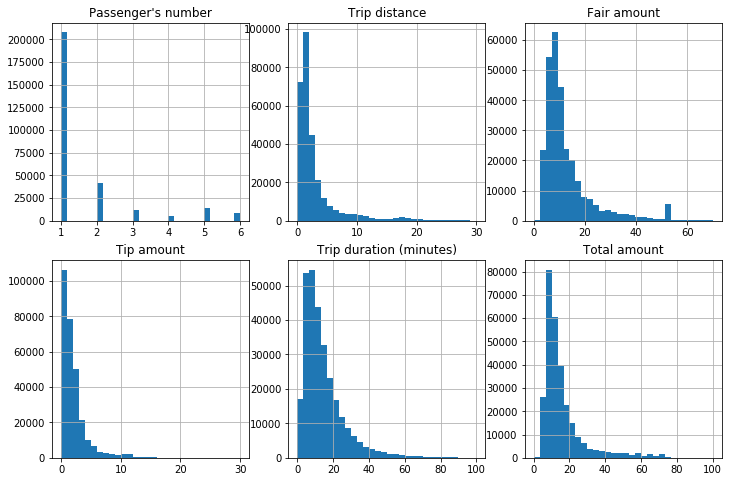

In [5]:
fig,ax = plt.subplots(2,3,figsize=(12,8))

data.passenger_count.hist(bins=30, ax=ax[0,0])
data.trip_distance.hist(bins=30, ax=ax[0,1], range = (0,30))
data.fare_amount.hist(bins=30, ax=ax[0,2], range = (0,70))
data.tip_amount.hist(bins=30, ax=ax[1,0], range = (0,30))
data.duration.hist(bins=30, ax=ax[1,1], range = (0,100))
data.total_amount.hist(bins=30, ax=ax[1,2], range = (0,100))


ax[0,0].set_title("Passenger's number")
ax[0,1].set_title('Trip distance')
ax[0,2].set_title("Fair amount")
ax[1,0].set_title("Tip amount")
ax[1,1].set_title("Trip duration (minutes)")
ax[1,2].set_title("Total amount")


plt.show()

- Most trips have a single passenger.
- The distribution of trip distance, fair amount, tip amount, trip duration and total amount look similar to a logistic distribution.

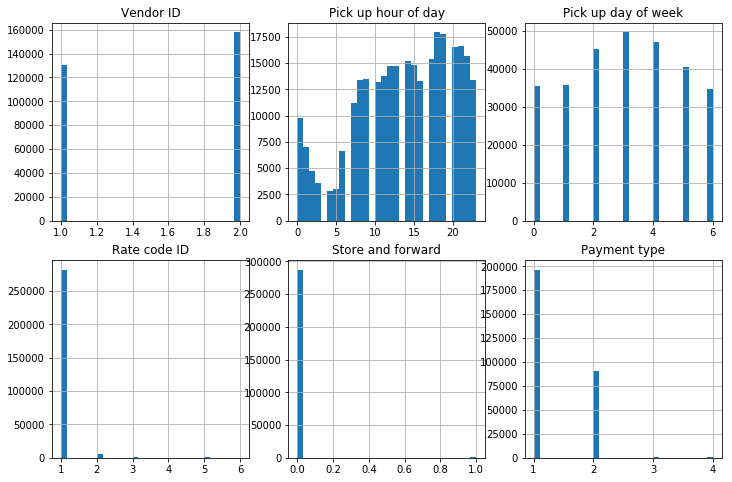

In [6]:
fig,ax = plt.subplots(2,3,figsize=(12,8))

data.VendorID.hist(bins=30, ax=ax[0,0])
data.pickup_hour.hist(bins=30, ax=ax[0,1])
data.pickup_day.hist(bins=30, ax=ax[0,2])
data.RatecodeID.hist(bins=30, ax=ax[1,0])
data.store_and_fwd_flag.hist(bins=30, ax=ax[1,1])
data.payment_type.hist(bins=30, ax=ax[1,2])



ax[0,0].set_title("Vendor ID")
ax[0,1].set_title("Pick up hour of day")
ax[0,2].set_title("Pick up day of week")
ax[1,0].set_title("Rate code ID")
ax[1,1].set_title("Store and forward")
ax[1,2].set_title("Payment type")

plt.show()

- The VeriFone Inc. has somewhat higher occupancy than CMT.
- Most trips are charged with a standard rate.
- Most trip records are related to 'connection to the server'.
- A credit card is the most used payment method, followed by cash payment.

The tip amount data is only based on credit card payments. When trips are paid by any other means we can't see how much was tipped, so the data reads 0. So, these zero data are not useful for this analysis. Also, I made a new column ("before_tip") that indicated the amount of a trip cost to a rider before tipping.

In [9]:
tip_data = data[(data['payment_type'] == 1) & (data['store_and_fwd_flag'] == 0)]
tip_data = tip_data.drop(['payment_type'], axis=1)
tip_data = tip_data.assign(before_tip = lambda x: (x.total_amount-x.tip_amount))

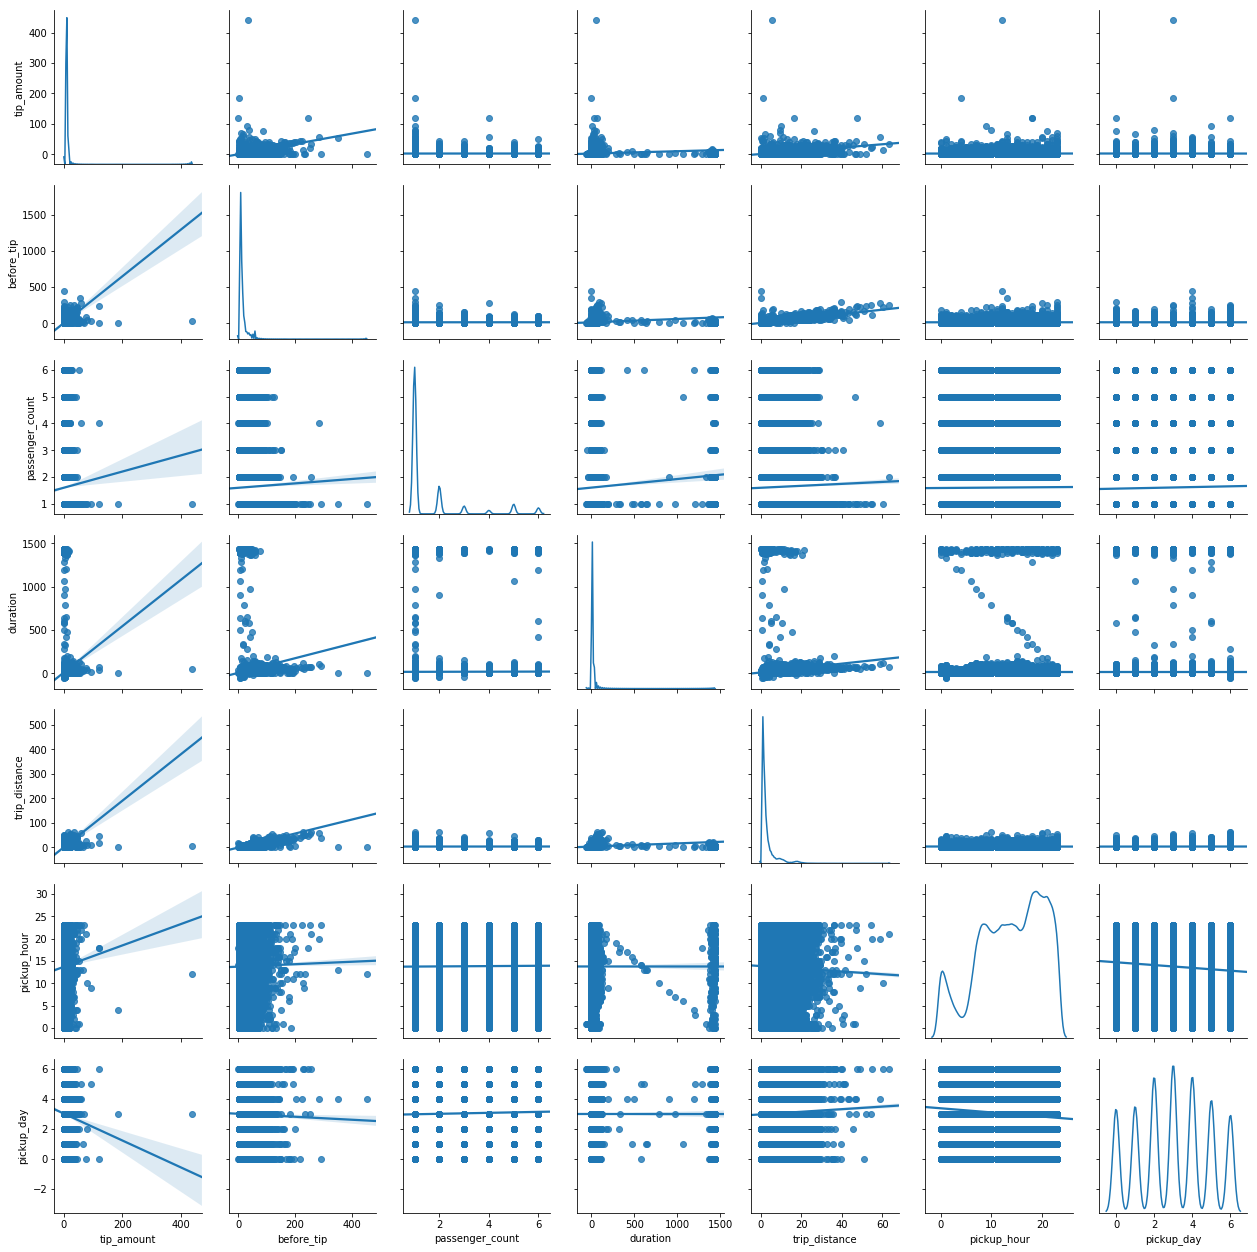

In [10]:
sns.pairplot(tip_data, 
             vars=['tip_amount','before_tip','passenger_count','duration','trip_distance','pickup_hour','pickup_day'], 
             diag_kind="kde", kind="reg")

plt.show()

- Tip amount has a relation with the total amount before tip. 

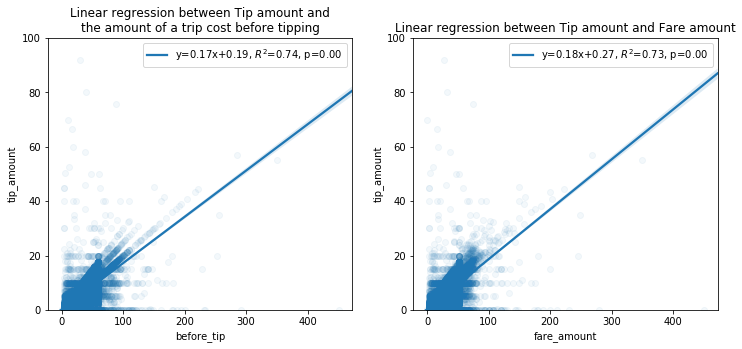

In [36]:
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
slope, intercept, r_value, p_value, std_err = stats.linregress(tip_data['before_tip'],tip_data['tip_amount'])

ax = sns.regplot(x="before_tip", y="tip_amount", data=tip_data,
 line_kws={'label':"y={0:.2f}x+{1:.2f}, $R^2$={2:.2f}, p={3:.2f} ".format(slope,intercept,r_value,p_value)},
                scatter_kws={'alpha':0.05})
ax.legend()
ax.axes.set_ylim(0,100)
ax.set_title("""Linear regression between Tip amount and
the amount of a trip cost before tipping""")

plt.subplot(1,2,2)
slope, intercept, r_value, p_value, std_err = stats.linregress(tip_data['fare_amount'],tip_data['tip_amount'])

ax = sns.regplot(x="fare_amount", y="tip_amount", data=tip_data,  
 line_kws={'label':"y={0:.2f}x+{1:.2f}, $R^2$={2:.2f}, p={3:.2f} ".format(slope,intercept,r_value,p_value)},
                scatter_kws={'alpha':0.05})
ax.legend()
ax.axes.set_ylim(0,100)
ax.set_title("Linear regression between Tip amount and Fare amount")
plt.show()
plt.show()

As seen in the above plots, a tip amount is highly related to a fair amount and to the whole fare before tipping. Curiously, it looks like passengers tip more at more expensive trips. So, I added new columns for the 'tip_percentage'.
- tip_percentage_1: aa a proportion of a fare amount
- tip_percentage_2: as a proportion of the whole amount before tipping

Also, I made a new column to indicate which trip had had a tip. (0: no tipping; 1: paid a tip)

In [13]:
tip_data = tip_data.assign(tip_percentage_1 = lambda x: (x.tip_amount/x.fare_amount)*100)
tip_data = tip_data.assign(tip_percentage_2 = lambda x: (x.tip_amount/(x.before_tip))*100)

In [14]:
tip_data['tip_no_paid'] = tip_data.tip_amount.isin([0]).astype(np.int64)

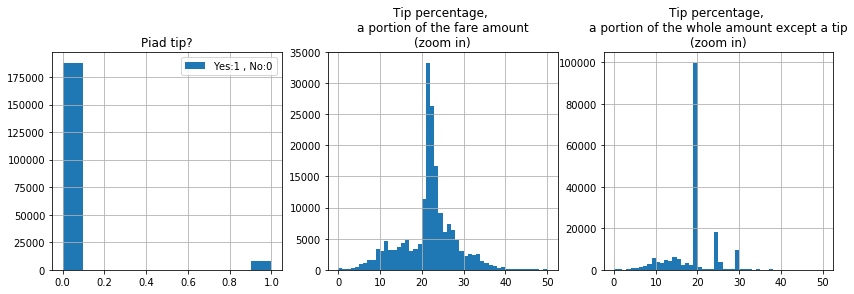

In [18]:
fig,ax = plt.subplots(1,3,figsize=(14,4))
tip_data.tip_no_paid.hist(ax=ax[0])
tip_data.tip_percentage_1[(tip_data['tip_percentage_1'] <=50)&(tip_data['tip_no_paid'] == 0)].hist(bins=50,ax=ax[1])

tip_data.tip_percentage_2[(tip_data['tip_percentage_2'] <=50)&(tip_data['tip_no_paid'] == 0)].hist(bins=50,ax=ax[2])

ax[0].set_title("Piad tip?")
ax[0].legend(['Yes:1 , No:0'])
ax[1].set_title("""Tip percentage, 
a portion of the fare amount
(zoom in)""")

ax[2].set_title("""Tip percentage, a portion of 
the amount of a trip cost before tipping
(zoom in)""")

plt.show()

Most passengers tipped. The distribution of tip percentage that was calculated by a portion of the fare amount seems a unimodal concentrated distribution. 
However when calculated a tip percentage by a portion of the total amount pay beforet tipping, we can see three picks, 20%, 25% and 30%.

- It looks like many passengers seem to make a default choice among the three options before tipping.
- According to [this video](https://www.youtube.com/watch?v=qdTtbc2-zeU) there are usually options to pay a tip. In this case there are three buttons. So, depanding on the programe that is representing to passenger choose a tip, the distribution of tip percentage and tip amount would be changed dramatically --e.g. if the screen offered a blank option to pay a tip, or only two options.
- Most passengers tip by selecting among these three options. I think that this way it's easy to tip. If someone wouldn't want to tip they should push the other button and put a tip amount on purpose. As generally people look for a taxi when they do not have time (personal hypothesis), selecting among the options to pay a tip looks the easiest option. 

In [19]:
tip_select = tip_data[(tip_data['tip_no_paid'] == 0)]

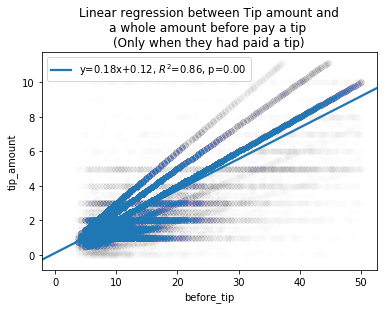

In [20]:
tip_select_ = tip_select[(np.abs(stats.zscore(tip_select[['tip_amount','before_tip']]))<3).all(axis=1)]


slope, intercept, r_value, p_value, std_err = stats.linregress(tip_select_['before_tip'],tip_select_['tip_amount'])

ax = sns.regplot(x="before_tip", y="tip_amount", data=tip_select_, 
 line_kws={'label':"y={0:.2f}x+{1:.2f}, $R^2$={2:.2f}, p={3:.2f} ".format(slope,intercept,r_value,p_value)},
                scatter_kws={'alpha':0.005})
ax.legend()
ax.set_title("""Linear regression between Tip amount and
a amount of a trip cost before tipping 
(Only when they had paid a tip)""")

plt.show()

When we focus on when passengers had paid a tip, they paid about 18% of the whole amount before tipping. In the above graph we could observe three diagonal lines (20, 25, 30%) and these lines indicate a tendency of tip percentage.Also, there are various horizontal lines.

So, what's different after eliminating the effect of the defalt options (20, 25, 30%)? 
I made a new variable "tip_decision" to see how much pay a tip when passengers would be going to pay a tip but not just select among these three options.

In [22]:
tip_decision = tip_data[(tip_data['tip_no_paid'] == 0)^
                        ((tip_data['tip_percentage_2'].round() ==20)|
                         (tip_data['tip_percentage_2'].round() ==25)|(tip_data['tip_percentage_2'].round() ==30))]

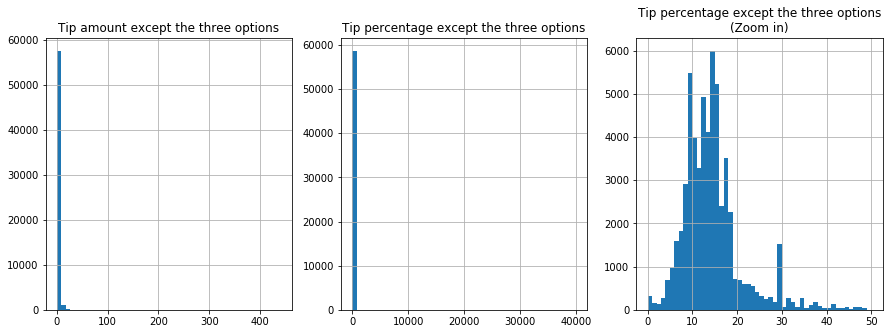

In [23]:
fig,ax = plt.subplots(1,3,figsize=(15,5))

tip_decision.tip_percentage_2.hist(bins=50, ax=ax[1])
tip_decision.tip_amount.hist(bins=50, ax=ax[0])
tip_decision.tip_percentage_2[tip_decision['tip_percentage_2'] < 50].hist(bins=50, ax=ax[2])

ax[1].set_title("Tip percentage except the three options")
ax[2].set_title("""Tip percentage except the three options
(Zoom in)""")
ax[0].set_title("Tip amount except the three options")

plt.show()

- After eliminate the three defalt options there is a slice tendency to select a tip amount like 15%, 10% or 18%.

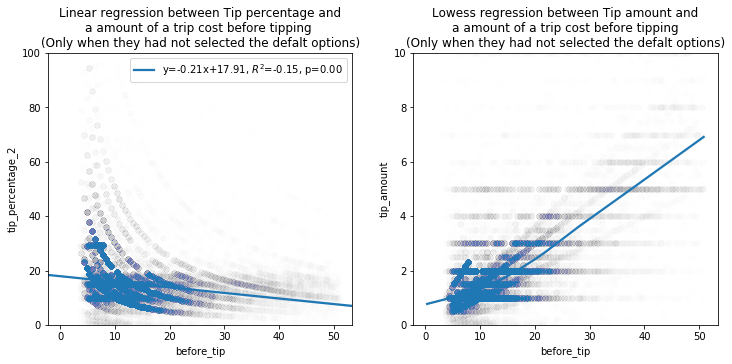

In [35]:
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)

tip_decision_ = tip_decision[(np.abs(stats.zscore(tip_decision[['tip_percentage_2','before_tip']]))<3).all(axis=1)]


slope, intercept, r_value, p_value, std_err = stats.linregress(tip_decision_['before_tip'],tip_decision_['tip_percentage_2'])

ax = sns.regplot(x="before_tip", y="tip_percentage_2", data=tip_decision_, 
 line_kws={'label':"y={0:.2f}x+{1:.2f}, $R^2$={2:.2f}, p={3:.2f} ".format(slope,intercept,r_value,p_value)},
                scatter_kws={'alpha':0.005})
ax.legend()
ax.axes.set_ylim(0,100)
ax.set_title("""Linear regression between Tip percentage and
a amount of a trip cost before tipping 
(Only when they had not selected the defalt options)""")

plt.subplot(1,2,2)

ax = sns.regplot(x="before_tip", y="tip_amount", data=tip_decision_,  lowess=True,
                scatter_kws={'alpha':0.005})
ax.axes.set_ylim(0,10)
ax.set_title("""Lowess regression between Tip amount and
a amount of a trip cost before tipping
(Only when they had not selected the defalt options)""")

plt.show()

- After eliminate the three default options, a tip percentage has a negative relationship with whole amount cost before tipping. 
- A passenger who tipped but did not select among the three options (20, 25, 30%) generally paid more of a tip as the whole amount increased. Although some pessengers payed a huge tip, generally they'd like to pay under 25 dollars.

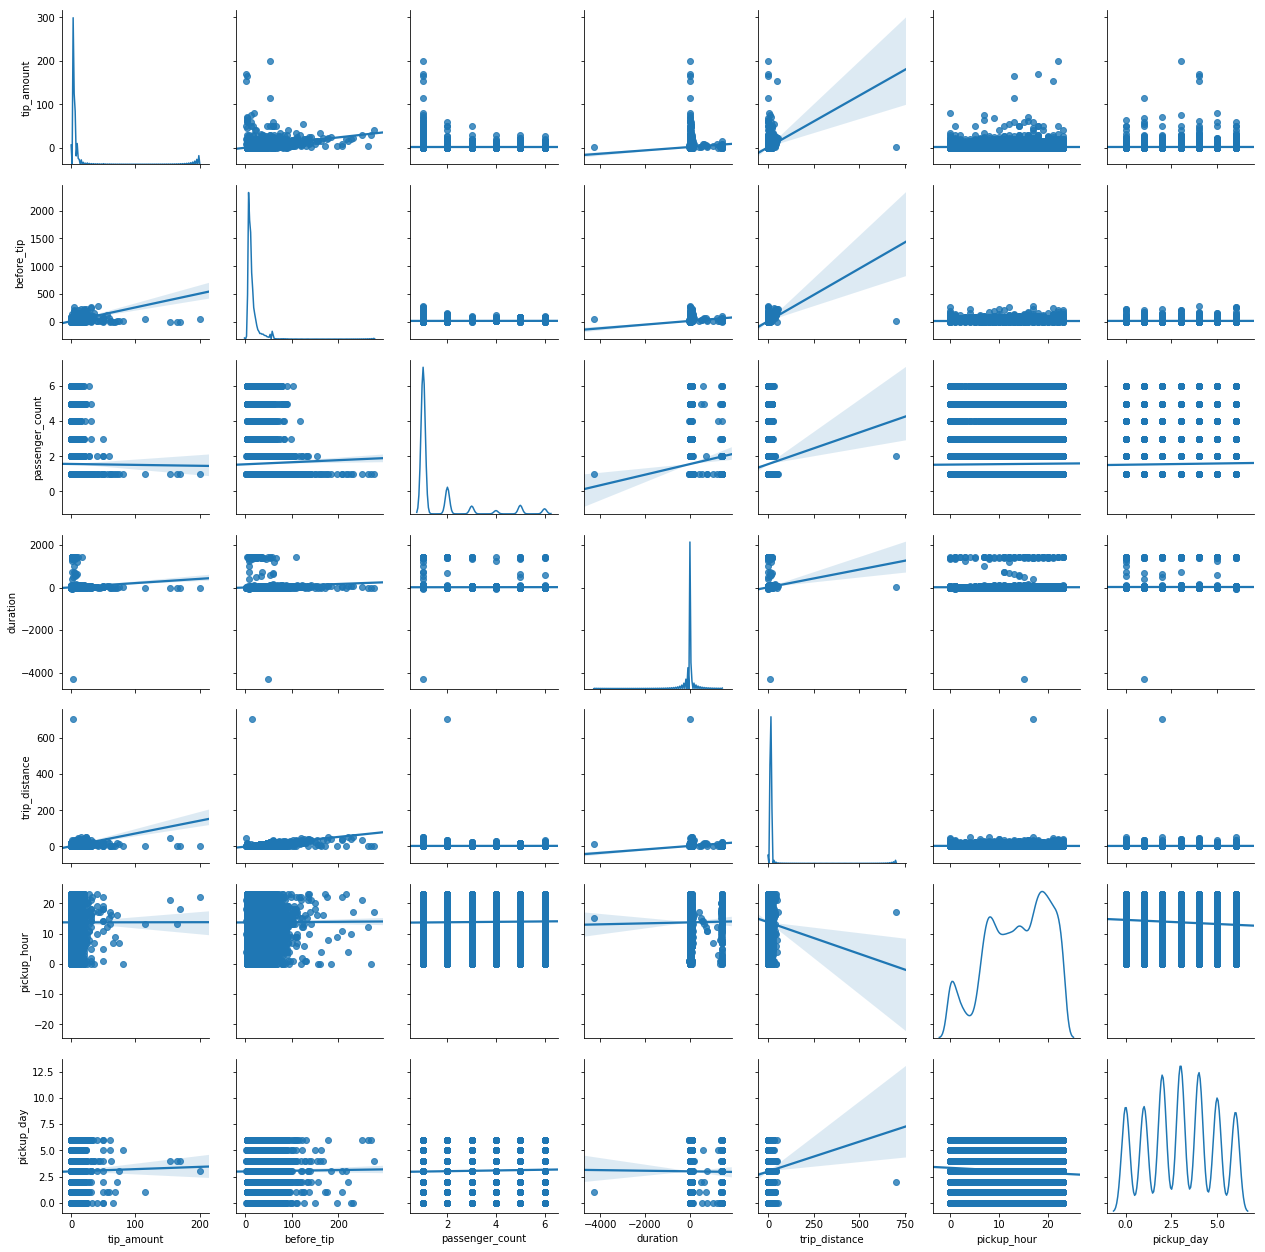

In [37]:
sns.pairplot(tip_decision, 
             vars=['tip_amount','before_tip','passenger_count','duration','trip_distance','pickup_hour','pickup_day'], 
             diag_kind="kde", kind="reg")

plt.show()


- When the three defalt options (20, 25, 30%) were eliminated there is a relationship between tip ampiunt and the other variable - before trip: a whole amount before pay a tip, trip distance and trip duration -.  

## Applied ML with Linear Regression

Until now, I treated only 1% of data. So, I will going to make a linear model to suggest a tip amount when the passenger do not want to pay among the defalt options.

In [37]:
allFiles = glob.glob("*.csv")
frame = pd.DataFrame()
list_ = []

for file_ in allFiles:
    num_lines = sum(1 for l in open(file_))

    df = pd.read_csv(file_, header=0, usecols=['tip_amount', 'total_amount', 'trip_distance','payment_type',
                                              'tpep_dropoff_datetime','tpep_pickup_datetime'])
    list_.append(df)
    
df = pd.concat(list_)

In [38]:
df['tpep_pickup_datetime'] = df.tpep_pickup_datetime.apply(lambda x:dt.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
df['tpep_dropoff_datetime'] = df.tpep_dropoff_datetime.apply(lambda x:dt.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))

df = df[(df['payment_type'] == 1)]

df['tip_no_paid'] = df.tip_amount.isin([0]).astype(np.int64)

df = df.assign(before_tip = lambda x: (x.total_amount-x.tip_amount))
df = df.assign(tip_percentage_2 = lambda x: (x.tip_amount/(x.total_amount-x.tip_amount))*100)
df = df.assign(trip_duration = lambda x: ((x.tpep_dropoff_datetime-x.tpep_pickup_datetime)/ np.timedelta64(1, 'm')))

### Linear model using a total amount before tipping

In [39]:
new_df = df[(df['tip_no_paid'] == 0)^
            ((df['tip_percentage_2'].round() ==20)|(df['tip_percentage_2'].round() ==25)|(df['tip_percentage_2'].round() ==30))]

In [40]:
new_df['log_tip_amount'] =new_df.tip_amount.apply(np.log)

new_df['log_before_tip'] = new_df.before_tip.apply(np.log)


new_df = new_df[['log_tip_amount','log_before_tip']]
new_df = new_df.rename(index=str, columns={"log_tip_amount": "tip_amount"})

In [41]:
new_df = new_df.replace([np.inf, -np.inf], np.nan).dropna()
new_df = new_df[(np.abs(stats.zscore(new_df[['tip_amount','log_before_tip']]))<3).all(axis=1)]

- I tried a log transformation due to a positively skewed data and eliminated outliers.

In [42]:
features = new_df.loc[:,new_df.columns != 'tip_amount']
targets = new_df.loc[:,new_df.columns == 'tip_amount']

X_train, X_test, y_train, y_test = train_test_split(features,targets, 
                                                    test_size=0.1, 
                                                    random_state=42)


In [43]:
reg_model = LinearRegression()

reg_model.fit(X_train, y_train)

print('Intercept :', reg_model.intercept_[0], '\n')
print(pd.DataFrame({'features':X_train.columns,'coeficients':reg_model.coef_[0]}))
print("Training set score: {:.2f}".format(reg_model.score(X_train, y_train)))

Intercept : -1.3656788948000544 

         features  coeficients
0  log_before_tip     0.746064
Training set score: 0.50


In [44]:
cv_reg_model = LinearRegression()
cv_scores = cross_val_score(cv_reg_model, features, targets,cv=100, scoring='r2')

print("\nAverage 100-Fold CV Score: {}".format(np.mean(cv_scores)))


Average 100-Fold CV Score: 0.492949712789756


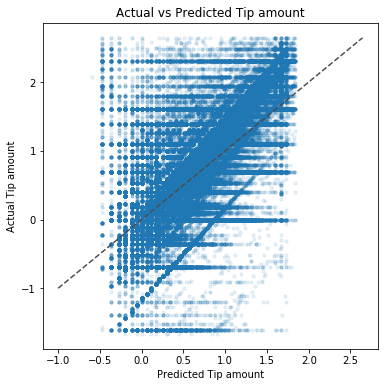

In [45]:
y_pred = reg_model.predict(X_test)

y_pred_a = pd.DataFrame(y_pred)
y_test_a = y_test.reset_index(drop=True, inplace=False)
pred_act_df = pd.concat([y_test_a,y_pred_a], axis=1).sort_values(1,axis=1).reset_index(drop=True)

plt.figure(figsize=(6, 6))
maxlimit = pred_act_df['tip_amount'].max()

plt.scatter(pred_act_df[0], pred_act_df['tip_amount'], s=10, alpha=0.1)
plt.xlabel('Predicted Tip amount')
plt.ylabel('Actual Tip amount')
plt.plot([-1,maxlimit], [-1,maxlimit], ls="--", c=".3")
plt.title('Actual vs Predicted Tip amount')
plt.show()

In [46]:
#for calculating MSE
y_pred_test = reg_model.predict(X_test)
y_pred_train = reg_model.predict(X_train)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))

print("Root Mean Squared Error of Training Set: {}".format(rmse_train))
print("Root Mean Squared Error of Testing Set: {}".format(rmse_test))

Root Mean Squared Error of Training Set: 0.43837789554147805
Root Mean Squared Error of Testing Set: 0.43802395636679736


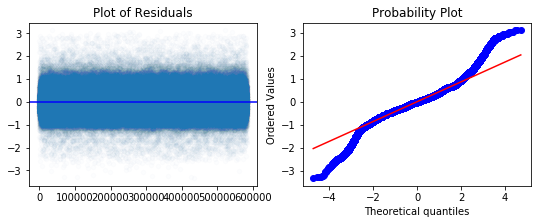

In [49]:
#calculate the residuals
y_pred = pd.DataFrame(y_pred)
y_test = y_test.reset_index(drop=True)
residuals = y_test.tip_amount - y_pred[0]

plt.figure(figsize=(9, 3))
plt.subplot(1,2,1)
plt.axhline(0, color="blue")
plt.title('Plot of Residuals')
plt.scatter(residuals.index,residuals, s=20, alpha=0.01)

plt.subplot(1,2,2)
plt.title('Probability Plot')
stats.probplot(residuals, dist='norm',plot=plt)
plt.show()

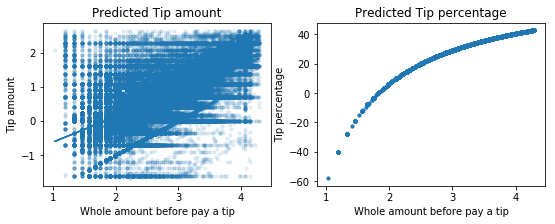

In [50]:
plt.figure(figsize=(9, 3))
plt.subplot(1,2,1)
y_pred = reg_model.predict(X_test)
plt.plot(X_test,y_pred)
plt.scatter(X_test, y_test, s=10, alpha=0.1)
plt.xlabel('Whole amount before pay a tip')
plt.ylabel('Tip amount')
plt.title('Predicted Tip amount')

plt.subplot(1,2,2)
y_pred_pc = (y_pred/X_test)*100
y_pred_pc = y_pred_pc.rename(index=str, columns={"log_before_tip": "tip_percentage"})
plt.scatter(X_test, y_pred_pc, s=10)
plt.xlabel('Whole amount before pay a tip')
plt.ylabel('Tip percentage')
plt.title('Predicted Tip percentage')

plt.show()

- The equation of the linear model to predict a tip amount using a total amount before tipping is:

log(*tip_amount*) = - 1.3657  + 0.7461 log(*whole amount before tipping*)


- This model could be close the data about 50%.

### Linear model using a total amount before tipping and a trip distance

In [53]:
new_df = df[(df['tip_no_paid'] == 0)^
            ((df['tip_percentage_2'].round() ==20)|(df['tip_percentage_2'].round() ==25)|(df['tip_percentage_2'].round() ==30))]

new_df['log_tip_amount'] =new_df.tip_amount.apply(np.log)
new_df['log_trip_distance'] =new_df.trip_distance.apply(np.log)
new_df['log_before_tip'] = new_df.before_tip.apply(np.log)


new_df = new_df[['log_tip_amount','log_before_tip', 'log_trip_distance']]
new_df = new_df.rename(index=str, columns={"log_tip_amount": "tip_amount"})

new_df = new_df.replace([np.inf, -np.inf], np.nan).dropna()
new_df = new_df[(np.abs(stats.zscore(new_df[['tip_amount','log_before_tip', 'log_trip_distance']]))<3).all(axis=1)]

In [54]:
features = new_df.loc[:,new_df.columns != 'tip_amount']
targets = new_df.loc[:,new_df.columns == 'tip_amount']

X_train, X_test, y_train, y_test = train_test_split(features,targets, 
                                                    test_size=0.1, 
                                                    random_state=42)

In [55]:
reg_model = LinearRegression()

reg_model.fit(X_train, y_train)

print('Intercept :', reg_model.intercept_[0], '\n')
print(pd.DataFrame({'features':X_train.columns,'coeficients':reg_model.coef_[0]}))
print("Training set score: {:.2f}".format(reg_model.score(X_train, y_train)))

Intercept : -1.489580434236626 

            features  coeficients
0     log_before_tip     0.803959
1  log_trip_distance    -0.035227
Training set score: 0.50


In [56]:
cv_reg_model = LinearRegression()
cv_scores = cross_val_score(cv_reg_model, features, targets,cv=100, scoring='r2')

print("\nAverage 100-Fold CV Score: {}".format(np.mean(cv_scores)))


Average 100-Fold CV Score: 0.5007446515391918


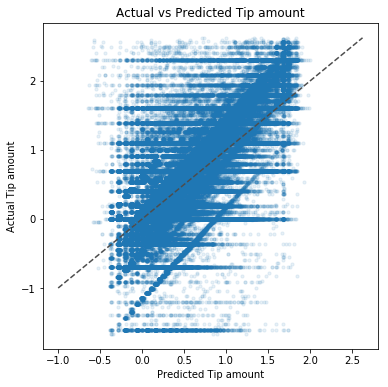

In [57]:
y_pred = reg_model.predict(X_test)

y_pred_a = pd.DataFrame(y_pred)
y_test_a = y_test.reset_index(drop=True, inplace=False)
pred_act_df = pd.concat([y_test_a,y_pred_a], axis=1).sort_values(1,axis=1).reset_index(drop=True)

plt.figure(figsize=(6, 6))
maxlimit = pred_act_df['tip_amount'].max()

plt.scatter(pred_act_df[0], pred_act_df['tip_amount'], s=10, alpha=0.1)
plt.xlabel('Predicted Tip amount')
plt.ylabel('Actual Tip amount')
plt.plot([-1,maxlimit], [-1,maxlimit], ls="--", c=".3")
plt.title('Actual vs Predicted Tip amount')
plt.show()

In [58]:
y_pred_test = reg_model.predict(X_test)
y_pred_train = reg_model.predict(X_train)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))

print("Root Mean Squared Error of Training Set: {}".format(rmse_train))
print("Root Mean Squared Error of Testing Set: {}".format(rmse_test))

Root Mean Squared Error of Training Set: 0.4320907466889751
Root Mean Squared Error of Testing Set: 0.43243227469036716


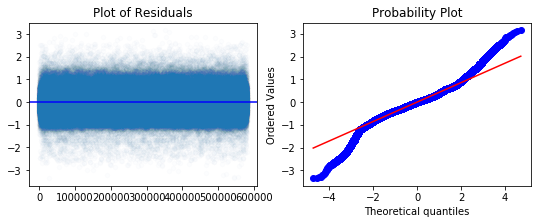

In [59]:
y_pred = pd.DataFrame(y_pred)
y_test = y_test.reset_index(drop=True)
residuals = y_test.tip_amount - y_pred[0]

plt.figure(figsize=(9, 3))
plt.subplot(1,2,1)
plt.axhline(0, color="blue")
plt.title('Plot of Residuals')
plt.scatter(residuals.index,residuals, s=20, alpha=0.01)

plt.subplot(1,2,2)
plt.title('Probability Plot')
stats.probplot(residuals, dist='norm',plot=plt)
plt.show()

- The equation of the linear model to predict a tip amount using a total amount before tipping is:

log(*tipamount*) = - 1.48  + 0.80 log(*whole amount before tipping*) - 0.03 log(*trip distance*)


- This model could be close the data about 50%.

### Linear model using a total amount before tipping, a trip duration and a trip distance

In [66]:
new_df = df[(df['tip_no_paid'] == 0)^
            ((df['tip_percentage_2'].round() ==20)|(df['tip_percentage_2'].round() ==25)|(df['tip_percentage_2'].round() ==30))]

new_df['log_tip_amount'] =new_df.tip_amount.apply(np.log)
new_df['log_trip_distance'] =new_df.trip_distance.apply(np.log)
new_df['log_before_tip'] = new_df.before_tip.apply(np.log)
new_df['log_trip_duration'] = new_df.trip_duration.apply(np.log)


new_df = new_df[['log_tip_amount','log_before_tip', 'log_trip_distance','log_trip_duration']]
new_df = new_df.rename(index=str, columns={"log_tip_amount": "tip_amount"})

new_df = new_df.replace([np.inf, -np.inf], np.nan).dropna()
new_df = new_df[(np.abs(stats.zscore(new_df[['tip_amount','log_before_tip',
                                             'log_trip_distance','log_trip_duration']]))<3).all(axis=1)]

In [67]:
features = new_df.loc[:,new_df.columns != 'tip_amount']
targets = new_df.loc[:,new_df.columns == 'tip_amount']

X_train, X_test, y_train, y_test = train_test_split(features,targets, 
                                                    test_size=0.1, 
                                                    random_state=42)

In [68]:
reg_model = LinearRegression()

reg_model.fit(X_train, y_train)

print('Intercept :', reg_model.intercept_[0], '\n')
print(pd.DataFrame({'features':X_train.columns,'coeficients':reg_model.coef_[0]}))
print("Training set score: {:.2f}".format(reg_model.score(X_train, y_train)))

Intercept : -1.8379199866471332 

            features  coeficients
0     log_before_tip     1.228342
1  log_trip_distance    -0.107657
2  log_trip_duration    -0.269895
Training set score: 0.52


In [69]:
cv_reg_model = LinearRegression()
cv_scores = cross_val_score(cv_reg_model, features, targets,cv=100, scoring='r2')

print("\nAverage 100-Fold CV Score: {}".format(np.mean(cv_scores)))


Average 100-Fold CV Score: 0.5157561060445919


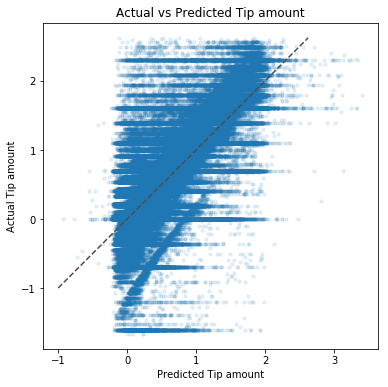

In [70]:
y_pred = reg_model.predict(X_test)

y_pred_a = pd.DataFrame(y_pred)
y_test_a = y_test.reset_index(drop=True, inplace=False)
pred_act_df = pd.concat([y_test_a,y_pred_a], axis=1).sort_values(1,axis=1).reset_index(drop=True)

plt.figure(figsize=(6, 6))
maxlimit = pred_act_df['tip_amount'].max()

plt.scatter(pred_act_df[0], pred_act_df['tip_amount'], s=10, alpha=0.1)
plt.xlabel('Predicted Tip amount')
plt.ylabel('Actual Tip amount')
plt.plot([-1,maxlimit], [-1,maxlimit], ls="--", c=".3")
plt.title('Actual vs Predicted Tip amount')
plt.show()

In [71]:
y_pred_test = reg_model.predict(X_test)
y_pred_train = reg_model.predict(X_train)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))

print("Root Mean Squared Error of Training Set: {}".format(rmse_train))
print("Root Mean Squared Error of Testing Set: {}".format(rmse_test))

Root Mean Squared Error of Training Set: 0.4248247060069628
Root Mean Squared Error of Testing Set: 0.4250030338035924


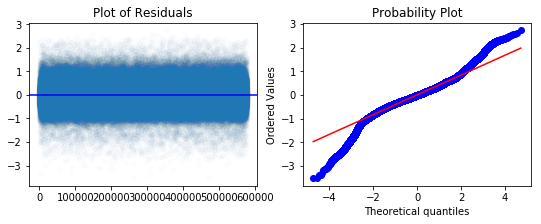

In [72]:
y_pred = pd.DataFrame(y_pred)
y_test = y_test.reset_index(drop=True)
residuals = y_test.tip_amount - y_pred[0]

plt.figure(figsize=(9, 3))
plt.subplot(1,2,1)
plt.axhline(0, color="blue")
plt.title('Plot of Residuals')
plt.scatter(residuals.index,residuals, s=20, alpha=0.01)

plt.subplot(1,2,2)
plt.title('Probability Plot')
stats.probplot(residuals, dist='norm',plot=plt)
plt.show()

- The equation of the linear model to predict a tip amount using a total amount before tipping is:

log(*tipamount*) = - 1.83  + 1.22 log(*whole amount before tipping*) - 0.1 log(*trip distance*) - 0.26 log(*trip duration*) 


- This model could be close the data about 52%.

## Conclusion

- The most passengers on a taxi make a decision choosing among the three tipping options: 20%, 25, 30%.
- That means depending on the how to present options to a rider (only two options: 25% and 30%; different three options: 15%, 20%, 25%; no defalt option just blank for putting a tip amount (dollar) or a tip percentage (%); etc.) that would be make a different data distribution.
- In order to see these matters A/B test is needed.
- Except choosing among the defalt options, these models could be predict a tip amount with the 50% of the variance.
- Using three variables (whole amount before tipping, trip distance, trip duration) the model score could be a little higher but the complexity also would be increased. So, the whole amount before tipping variable is sufficient.
- I tried a gradient boosting model to predict if they do not want to choose a defalt how much would tip.